# 18.1 From ATE to CATE

**Chapter**: 18 - Heterogeneous Treatment Effects  
**Section**: 1 - From ATE to CATE  
**Facure Source**: 18-Heterogeneous-Treatment-Effects-and-Personalization.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-16

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [From Predictions to Causal Inference](#11-from-predictions-to-causal-inference)
   - 1.2 [The Treatment as a Decision Variable](#12-the-treatment-as-a-decision-variable)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [ATE Review](#21-ate-review)
   - 2.2 [CATE Definition](#22-cate-definition)
   - 2.3 [Individual Treatment Effect](#23-individual-treatment-effect)
3. [Why Heterogeneity Matters](#3-why-heterogeneity-matters)
   - 3.1 [The Personalization Goal](#31-the-personalization-goal)
   - 3.2 [Individual Slopes Intuition](#32-individual-slopes-intuition)
4. [Numeric Demonstration](#4-numeric-demonstration)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, stats,
    load_facure_data,
    set_notebook_style,
    create_tufte_figure,
    apply_tufte_style,
    TUFTE_PALETTE,
    COLORS,
)

set_notebook_style()
np.random.seed(42)

print("Imports loaded successfully")

Imports loaded successfully


---

## 1. Facure's Intuition

> **Interview Relevance**: Understanding the distinction between ATE and CATE is fundamental for any causal inference role. Expect questions about when and why you'd estimate heterogeneous effects.

### 1.1 From Predictions to Causal Inference

In Part I of our causal journey, we focused on **program evaluation**: does the treatment work **on average**? We answered questions like:

- Does education increase earnings?
- Does a discount increase conversion?
- Does a drug reduce blood pressure?

These are **Average Treatment Effect (ATE)** questions. We wanted to know if rolling out a treatment to the entire population is a good idea.

But in the real world, decision-making is often more nuanced:

```
From Prediction to Personalization ───────────────────────

  ML Prediction:        E[Y | X]
                         "What will happen?"
                         
  Causal (ATE):         E[Y(1) - Y(0)]
                         "Does treatment work?"
                         
  Causal (CATE):        E[Y(1) - Y(0) | X]
                         "Who should be treated?"
                         "How much should we treat?"
─────────────────────────────────────────────────────────
```

### 1.2 The Treatment as a Decision Variable

Machine learning models estimate $E[Y|X]$ — passive observation.

But in many business contexts, **we are part of the data generating process**. We can choose:
- What price to charge
- What discount to offer
- What email to send
- What loan amount to approve

The key insight:

$$E[Y|X, T]$$

Where:
- $X$ = **context features** (things we observe but can't control)
- $T$ = **treatment** (things we can decide)
- $Y$ = **outcome** (what we want to optimize)

**Goal**: Find the optimal treatment for each unit:

$$T^*(x) = \underset{t}{\arg\max} \ E[Y|X=x, T=t]$$

In [2]:
# Load the ice cream sales data (randomized for clean CATE identification)
prices_rnd = load_facure_data('ice_cream_sales_rnd.csv')

print("=" * 60)
print("ICE CREAM SALES DATA")
print("=" * 60)
print(f"\nDataset size: {len(prices_rnd):,} daily observations")
print(f"\nColumns: {list(prices_rnd.columns)}")
print(f"\nVariables:")
print(f"  - temp: Temperature (Celsius)")
print(f"  - weekday: Day of week (1-7)")
print(f"  - cost: Production cost (proxy for quality)")
print(f"  - price: Ice cream price (TREATMENT)")
print(f"  - sales: Number sold (OUTCOME)")

ICE CREAM SALES DATA

Dataset size: 5,000 daily observations

Columns: ['temp', 'weekday', 'cost', 'price', 'sales']

Variables:
  - temp: Temperature (Celsius)
  - weekday: Day of week (1-7)
  - cost: Production cost (proxy for quality)
  - price: Ice cream price (TREATMENT)
  - sales: Number sold (OUTCOME)


In [3]:
print("Data sample:")
print(prices_rnd.head())

print(f"\n" + "=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)
print(prices_rnd.describe().round(2))

Data sample:
     temp  weekday   cost  price  sales
0 25.8000        1 0.3000      7    230
1 22.7000        3 0.5000      4    190
2 33.7000        7 1.0000      5    237
3 23.0000        4 0.5000      5    193
4 24.4000        1 1.0000      3    252

SUMMARY STATISTICS
           temp   weekday      cost     price     sales
count 5000.0000 5000.0000 5000.0000 5000.0000 5000.0000
mean    23.9900    4.0200    0.8200    6.5300  202.4800
std      4.0600    2.0100    0.4600    2.3000   21.3400
min      9.6000    1.0000    0.3000    3.0000  139.0000
25%     21.2000    2.0000    0.5000    5.0000  188.0000
50%     24.1000    4.0000    1.0000    7.0000  199.0000
75%     26.7000    6.0000    1.0000    9.0000  214.0000
max     38.4000    7.0000    1.5000   10.0000  264.0000


---

## 2. Formal Treatment

### 2.1 ATE Review

Using potential outcomes notation, the **Average Treatment Effect** is:

$$\tau_{ATE} = E[Y(1) - Y(0)]$$

For a continuous treatment (like price), we care about the **marginal effect**:

$$\tau_{ATE} = E\left[\frac{\partial Y}{\partial T}\right]$$

ATE tells us about the **average** effect across all units. It's:
- Great for program evaluation ("should we do this at all?")
- Insufficient for personalization ("who should we target?")

### 2.2 CATE Definition

The **Conditional Average Treatment Effect** conditions on covariates:

$$\tau(x) = E[Y(1) - Y(0) | X = x]$$

For continuous treatment:

$$\tau(x) = E\left[\frac{\partial Y}{\partial T} \Big| X = x\right]$$

**Key properties**:

1. **Heterogeneity**: $\tau(x)$ can vary with $x$
2. **Aggregation**: $ATE = E_X[\tau(X)]$ (average over CATE)
3. **Personalization**: Different $\tau(x)$ enables targeting

### 2.3 Individual Treatment Effect

The **Individual Treatment Effect (ITE)** is:

$$\tau_i = Y_i(1) - Y_i(0)$$

**Fundamental Problem of Causal Inference**: We never observe both $Y_i(1)$ and $Y_i(0)$ for the same unit.

```
CATE vs ITE ─────────────────────────────────────────────

  ITE:   τᵢ = Yᵢ(1) - Yᵢ(0)
         Individual level, NEVER observable
         
  CATE:  τ(x) = E[Y(1) - Y(0) | X = x]
         Average for units with same X, identifiable
         
  We estimate CATE as our "best guess" of ITE for unit i
─────────────────────────────────────────────────────────
```

In [4]:
# Demonstrate ATE vs CATE with the ice cream data
import statsmodels.formula.api as smf

# ATE model (no interactions - constant effect)
ate_model = smf.ols("sales ~ price + temp + C(weekday) + cost", data=prices_rnd).fit()

print("=" * 60)
print("ATE MODEL: Constant Price Effect")
print("=" * 60)
print(f"\nPrice coefficient (ATE): {ate_model.params['price']:.3f}")
print(f"\nInterpretation: On average, each $1 increase in price")
print(f"                decreases sales by {abs(ate_model.params['price']):.1f} units")
print(f"\nThis is the SAME effect for ALL days!")

ATE MODEL: Constant Price Effect

Price coefficient (ATE): -2.695

Interpretation: On average, each $1 increase in price
                decreases sales by 2.7 units

This is the SAME effect for ALL days!


In [5]:
# CATE model (with interactions - heterogeneous effect)
cate_model = smf.ols("sales ~ price*temp + price*cost + price*C(weekday)", data=prices_rnd).fit()

print("=" * 60)
print("CATE MODEL: Heterogeneous Price Effect")
print("=" * 60)
print(f"\nBase price effect: {cate_model.params['price']:.3f}")
print(f"Price × temp interaction: {cate_model.params['price:temp']:.4f}")
print(f"\nInterpretation:")
print(f"  - Baseline sensitivity (at temp=0): {cate_model.params['price']:.2f}")
print(f"  - Each 1°C increase: sensitivity increases by {cate_model.params['price:temp']:.3f}")
print(f"\n  At 20°C: effect = {cate_model.params['price'] + 20*cate_model.params['price:temp']:.2f}")
print(f"  At 30°C: effect = {cate_model.params['price'] + 30*cate_model.params['price:temp']:.2f}")
print(f"\n  Hotter days → Less price sensitive!")

CATE MODEL: Heterogeneous Price Effect

Base price effect: -11.960
Price × temp interaction: 0.0752

Interpretation:
  - Baseline sensitivity (at temp=0): -11.96
  - Each 1°C increase: sensitivity increases by 0.075

  At 20°C: effect = -10.46
  At 30°C: effect = -9.70

  Hotter days → Less price sensitive!


---

## 3. Implementation: Why Heterogeneity Matters

### 3.1 The Personalization Goal

Consider our ice cream seller:

- **ATE thinking**: "People are sensitive to price. I should keep prices low."
- **CATE thinking**: "People are sensitive on cool days, but on hot days they'll pay more!"

With CATE, we can:

1. **Segment**: Group units by predicted treatment effect
2. **Target**: Apply treatment only to responsive units
3. **Personalize**: Optimize treatment level for each unit

```
Personalization Framework ───────────────────────────────

  1. Estimate τ(x) for each unit
  2. Segment: group by predicted effect
  3. Decide:
     - High τ(x): treat aggressively
     - Low τ(x): treat conservatively
     - Negative τ(x): don't treat!
─────────────────────────────────────────────────────────
```

### 3.2 Individual Slopes Intuition

Here's the key mental model:

Think of each unit $i$ as having its own "slope" $\frac{\partial Y_i}{\partial T_i}$.

- Some units have **steep slopes** (highly responsive to treatment)
- Some units have **flat slopes** (unresponsive)
- Some might have **negative slopes** in one direction (treatment helps) and positive in another

We can't observe these individual slopes directly, but we can **predict** them using $X$!

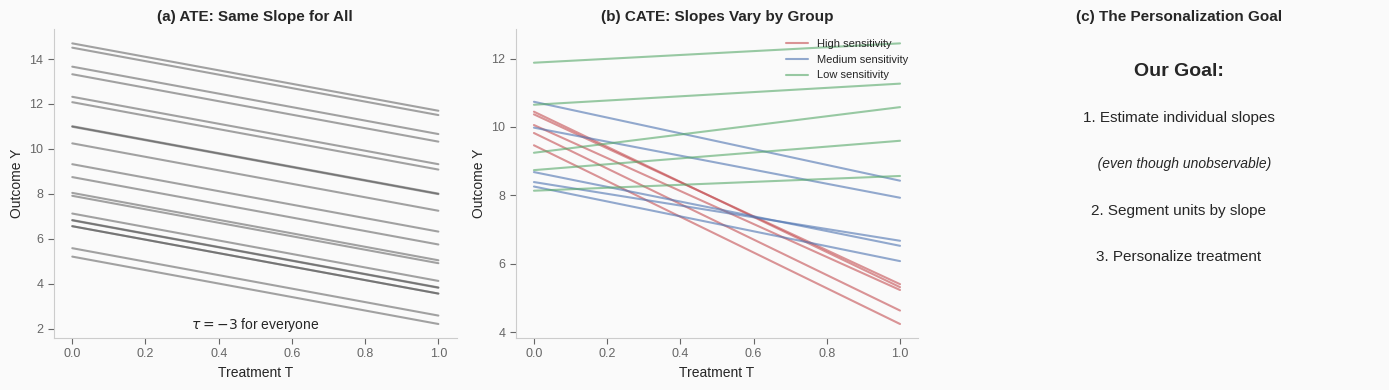

In [6]:
# Visualize the individual slopes concept
fig, axes = create_tufte_figure(1, 3, figsize=(14, 4))

# Panel 1: ATE - all units have same slope
ax = axes[0]
np.random.seed(42)
n_lines = 20
for i in range(n_lines):
    x = np.array([0, 1])
    y_start = np.random.uniform(5, 15)
    slope = -3  # Same for everyone (ATE)
    y = y_start + slope * x
    ax.plot(x, y, alpha=0.5, c=TUFTE_PALETTE['primary'], lw=1.5)

ax.set_xlabel('Treatment T')
ax.set_ylabel('Outcome Y')
ax.set_title('(a) ATE: Same Slope for All', fontweight='bold')
ax.text(0.5, 2, r'$\tau = -3$ for everyone', fontsize=10, ha='center')

# Panel 2: CATE - slopes vary by group
ax = axes[1]
groups = [(-5, 'High sensitivity', COLORS['red']),
          (-2, 'Medium sensitivity', COLORS['blue']),
          (0.5, 'Low sensitivity', COLORS['green'])]

for slope, label, color in groups:
    for i in range(5):
        x = np.array([0, 1])
        y_start = np.random.uniform(8, 12)
        y = y_start + (slope + np.random.normal(0, 0.3)) * x
        ax.plot(x, y, alpha=0.6, c=color, lw=1.5, label=label if i==0 else '')

ax.set_xlabel('Treatment T')
ax.set_ylabel('Outcome Y')
ax.set_title('(b) CATE: Slopes Vary by Group', fontweight='bold')
ax.legend(loc='upper right', frameon=False, fontsize=8)

# Panel 3: Our goal - estimate and segment by slope
ax = axes[2]
ax.text(0.5, 0.85, 'Our Goal:', fontsize=14, fontweight='bold', 
        ha='center', transform=ax.transAxes)
ax.text(0.5, 0.7, '1. Estimate individual slopes', fontsize=11, 
        ha='center', transform=ax.transAxes)
ax.text(0.5, 0.55, '   (even though unobservable)', fontsize=10, 
        ha='center', transform=ax.transAxes, style='italic')
ax.text(0.5, 0.4, '2. Segment units by slope', fontsize=11, 
        ha='center', transform=ax.transAxes)
ax.text(0.5, 0.25, '3. Personalize treatment', fontsize=11, 
        ha='center', transform=ax.transAxes)
ax.axis('off')
ax.set_title('(c) The Personalization Goal', fontweight='bold')

plt.tight_layout()
plt.show()

---

## 4. Numeric Demonstration

Let's compute and visualize CATE estimates for our ice cream data.

In [7]:
# Compute CATE predictions using the numerical approximation
def predict_sensitivity(model, df, t_col='price', h=0.01):
    """
    Predict CATE using numerical derivative approximation.
    
    dY/dT ≈ (Y(T+h) - Y(T)) / h
    """
    df_plus = df.copy()
    df_plus[t_col] = df[t_col] + h
    return (model.predict(df_plus) - model.predict(df)) / h

# Compute predicted sensitivity for each day
prices_rnd = prices_rnd.copy()
prices_rnd['cate_pred'] = predict_sensitivity(cate_model, prices_rnd)

print("CATE (Price Sensitivity) Predictions:")
print(f"  Mean:   {prices_rnd['cate_pred'].mean():.3f}")
print(f"  Std:    {prices_rnd['cate_pred'].std():.3f}")
print(f"  Min:    {prices_rnd['cate_pred'].min():.3f}")
print(f"  Max:    {prices_rnd['cate_pred'].max():.3f}")
print(f"\nCompare to ATE: {ate_model.params['price']:.3f}")

CATE (Price Sensitivity) Predictions:
  Mean:   -2.724
  Std:    4.677
  Min:    -10.991
  Max:    1.520

Compare to ATE: -2.695


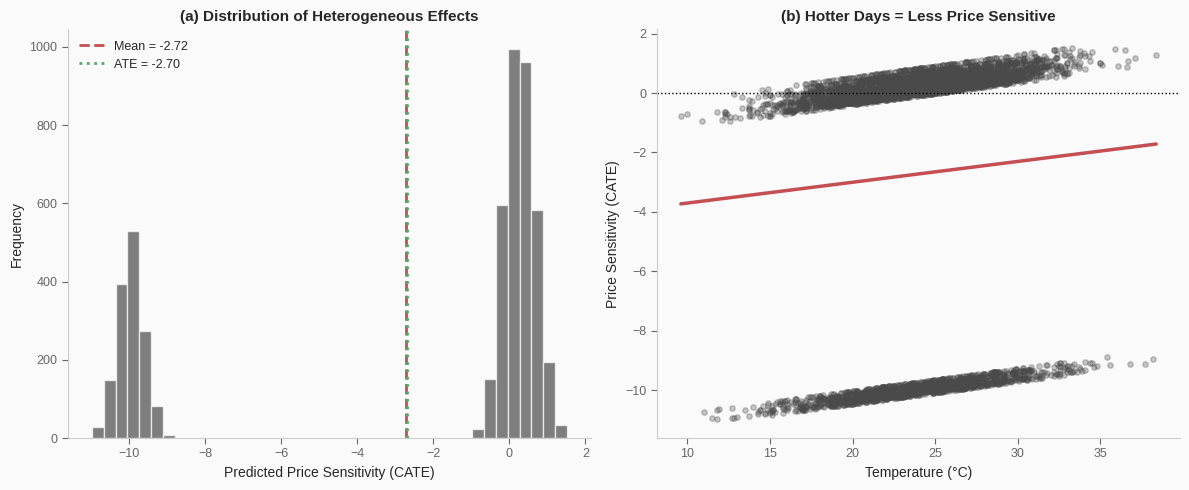


Key insight: On hot days, customers are willing to pay more!


In [8]:
# Show how CATE varies with temperature
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Panel 1: Distribution of CATE
ax = axes[0]
ax.hist(prices_rnd['cate_pred'], bins=40, color=TUFTE_PALETTE['primary'], 
        alpha=0.7, edgecolor='white')
ax.axvline(prices_rnd['cate_pred'].mean(), color=COLORS['red'], 
           linestyle='--', lw=2, label=f"Mean = {prices_rnd['cate_pred'].mean():.2f}")
ax.axvline(ate_model.params['price'], color=COLORS['green'], 
           linestyle=':', lw=2, label=f"ATE = {ate_model.params['price']:.2f}")
ax.set_xlabel('Predicted Price Sensitivity (CATE)')
ax.set_ylabel('Frequency')
ax.set_title('(a) Distribution of Heterogeneous Effects', fontweight='bold')
ax.legend(frameon=False)

# Panel 2: CATE vs Temperature
ax = axes[1]
ax.scatter(prices_rnd['temp'], prices_rnd['cate_pred'], 
           alpha=0.3, s=15, c=TUFTE_PALETTE['primary'])

# Add regression line
z = np.polyfit(prices_rnd['temp'], prices_rnd['cate_pred'], 1)
p = np.poly1d(z)
temp_range = np.linspace(prices_rnd['temp'].min(), prices_rnd['temp'].max(), 100)
ax.plot(temp_range, p(temp_range), c=COLORS['red'], lw=2.5, label='Trend')

ax.axhline(0, color='black', linestyle=':', lw=1)
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Price Sensitivity (CATE)')
ax.set_title('(b) Hotter Days = Less Price Sensitive', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nKey insight: On hot days, customers are willing to pay more!")

In [9]:
# Segment by CATE and show how to use it for pricing decisions
prices_rnd['sensitivity_group'] = pd.qcut(prices_rnd['cate_pred'], q=3, 
                                           labels=['High Sensitivity', 
                                                   'Medium Sensitivity', 
                                                   'Low Sensitivity'])

print("=" * 60)
print("SEGMENTATION BY PRICE SENSITIVITY")
print("=" * 60)

summary = prices_rnd.groupby('sensitivity_group').agg({
    'cate_pred': ['mean', 'min', 'max'],
    'temp': 'mean',
    'sales': 'mean',
    'price': 'mean'
}).round(2)

print(summary)

print("\n" + "=" * 60)
print("PRICING STRATEGY RECOMMENDATIONS")
print("=" * 60)
print("\nHigh Sensitivity (cooler days):")
print("  -> Keep prices LOW to maintain sales volume")
print("\nLow Sensitivity (hotter days):")
print("  -> Can RAISE prices without losing many sales")

SEGMENTATION BY PRICE SENSITIVITY
                   cate_pred                     temp    sales  price
                        mean      min     max    mean     mean   mean
sensitivity_group                                                    
High Sensitivity     -8.8200 -10.9900 -0.3400 23.1700 214.0900 6.6100
Medium Sensitivity    0.0300  -0.3300  0.3000 22.2600 189.4700 6.4100
Low Sensitivity       0.6200   0.3000  1.5200 26.5500 203.8800 6.5800

PRICING STRATEGY RECOMMENDATIONS

High Sensitivity (cooler days):
  -> Keep prices LOW to maintain sales volume

Low Sensitivity (hotter days):
  -> Can RAISE prices without losing many sales


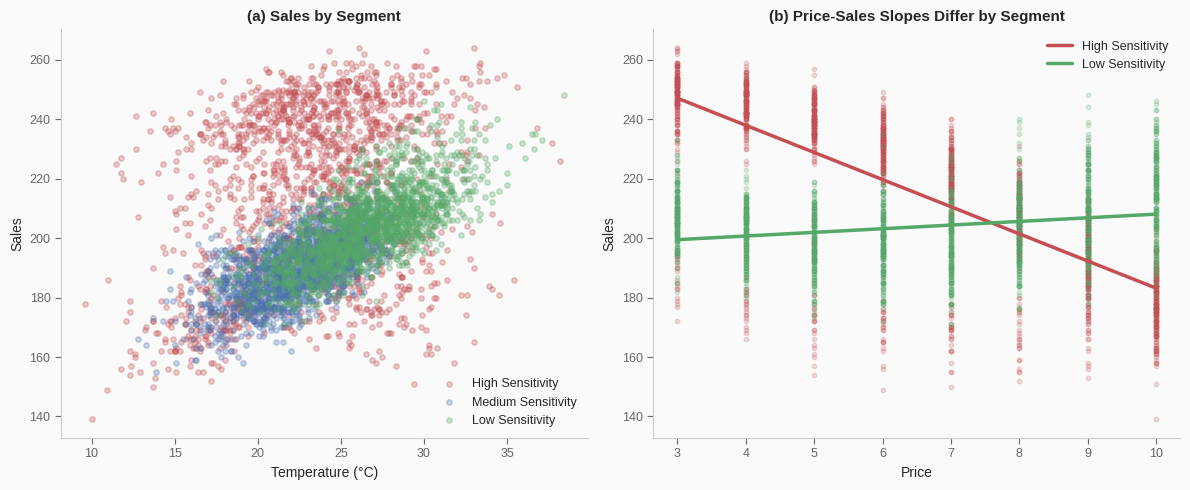


Red (high sensitivity) has a steeper negative slope!
Green (low sensitivity) has a flatter slope - prices matter less.


In [10]:
# Visualize the segments
import seaborn as sns

fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Panel 1: Scatterplot by segment
ax = axes[0]
colors_map = {'High Sensitivity': COLORS['red'], 
              'Medium Sensitivity': COLORS['blue'], 
              'Low Sensitivity': COLORS['green']}

for group in ['High Sensitivity', 'Medium Sensitivity', 'Low Sensitivity']:
    subset = prices_rnd[prices_rnd['sensitivity_group'] == group]
    ax.scatter(subset['temp'], subset['sales'], alpha=0.3, s=15, 
               c=colors_map[group], label=group)

ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Sales')
ax.set_title('(a) Sales by Segment', fontweight='bold')
ax.legend(frameon=False, fontsize=9)

# Panel 2: Price-Sales relationship by segment
ax = axes[1]
for group in ['High Sensitivity', 'Low Sensitivity']:
    subset = prices_rnd[prices_rnd['sensitivity_group'] == group]
    z = np.polyfit(subset['price'], subset['sales'], 1)
    p = np.poly1d(z)
    price_range = np.linspace(subset['price'].min(), subset['price'].max(), 100)
    ax.plot(price_range, p(price_range), c=colors_map[group], lw=2.5, label=group)
    ax.scatter(subset['price'], subset['sales'], alpha=0.2, s=10, c=colors_map[group])

ax.set_xlabel('Price')
ax.set_ylabel('Sales')
ax.set_title('(b) Price-Sales Slopes Differ by Segment', fontweight='bold')
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

print("\nRed (high sensitivity) has a steeper negative slope!")
print("Green (low sensitivity) has a flatter slope - prices matter less.")

```
Key Takeaways ───────────────────────────────────────────

1. ATE gives one number for everyone
   - Good for "should we do this at all?"
   - Not enough for personalization

2. CATE varies by unit characteristics
   - τ(x) = E[Y(1) - Y(0) | X = x]
   - Enables segmentation and targeting

3. Individual slopes are unobservable
   - But we can PREDICT them from X
   - Linear regression with interactions is simplest approach
   
4. Next steps:
   - How to build better CATE models
   - How to evaluate if they're working
─────────────────────────────────────────────────────────
```

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E5, DS)**: *"What is CATE and why might you estimate it instead of ATE?"*

<details>
<summary>Solution</summary>

**CATE Definition**:

$$\tau(x) = E[Y(1) - Y(0) | X = x]$$

The Conditional Average Treatment Effect is the average treatment effect for units with covariates $X = x$.

**When to estimate CATE instead of ATE**:

1. **Personalization**: You want to target treatment to responsive units
   - Example: Discounts only to price-sensitive customers
   
2. **Resource constraints**: Limited budget, can't treat everyone
   - Example: Marketing budget forces prioritization
   
3. **Potential harm**: Treatment might hurt some subgroups
   - Example: Drug with side effects for elderly patients
   
4. **Mechanism understanding**: Learn WHY treatment works
   - Example: Which features drive treatment response?

**Relationship to ATE**:

$$ATE = E_X[\tau(X)]$$

ATE is just the average of CATE across the population.

</details>

---

**Q2 (Amazon L6, Econ)**: *"How do you estimate CATE using linear regression?"*

<details>
<summary>Solution</summary>

**Basic approach: Interaction terms**

1. **ATE model** (no heterogeneity):
   $$Y_i = \beta_0 + \beta_1 T_i + \beta_2 X_i + \epsilon_i$$
   
   CATE: $\hat{\tau} = \beta_1$ (constant for everyone)

2. **CATE model** (with interactions):
   $$Y_i = \beta_0 + \beta_1 T_i + \beta_2 X_i + \beta_3 (T_i \cdot X_i) + \epsilon_i$$
   
   CATE: $\hat{\tau}(x) = \beta_1 + \beta_3 x$ (varies with $X$)

**Numerical approximation** (more general):

For any model $\hat{\mu}(X, T)$:

$$\hat{\tau}(x) = \hat{\mu}(x, T+h) - \hat{\mu}(x, T) / h$$

With $h$ small (e.g., 0.01).

**For binary treatment**:

$$\hat{\tau}(x) = \hat{\mu}(x, 1) - \hat{\mu}(x, 0)$$

**Limitations**: 
- Assumes linear heterogeneity
- May miss complex interactions
- Meta-learners (S, T, X, R) can use flexible ML models

</details>

---

**Q3 (Google L5, Quant)**: *"Why can't we observe individual treatment effects?"*

<details>
<summary>Solution</summary>

**The Fundamental Problem of Causal Inference**:

The individual treatment effect is:

$$\tau_i = Y_i(1) - Y_i(0)$$

But for any unit $i$, we observe:

$$Y_i = T_i \cdot Y_i(1) + (1 - T_i) \cdot Y_i(0)$$

We only see **one** potential outcome — the one corresponding to the treatment actually received.

**Why this is fundamental**:

1. We cannot time-travel to see the counterfactual
2. We cannot clone units to observe both outcomes
3. Treatment is a one-time event for each unit at each moment

**What we CAN do**:

1. **ATE**: Average over many units to estimate $E[Y(1) - Y(0)]$
2. **CATE**: Estimate average for units with same $X$
3. **Predict ITE**: Use CATE as our best guess for individual $i$

**Key distinction**:
- ITE is never observed
- CATE is identifiable under assumptions (unconfoundedness, overlap)
- We use CATE estimates as proxies for ITE

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 18: "Heterogeneous Treatment Effects and Personalization."

[^2]: Athey, S. and Imbens, G. W. (2016). Recursive partitioning for heterogeneous causal effects. *PNAS*, 113(27), 7353-7360.

[^3]: Kunzel, S. R., Sekhon, J. S., Bickel, P. J., and Yu, B. (2019). Metalearners for estimating heterogeneous treatment effects using machine learning. *PNAS*, 116(10), 4156-4165.

[^4]: Chernozhukov, V. et al. (2018). Double/Debiased Machine Learning for Treatment and Structural Parameters. *The Econometrics Journal*, 21(1), C1-C68.

---

**Next**: [02. Estimating Heterogeneity](./02_estimating_heterogeneity.ipynb) — Building CATE models with interaction terms